# Load Packages and State Paths

In [3]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib

final_project_path = '/home/jws2215/e6691-2024spring-project-jwss-jws2215' # vm
data_folder_path = os.path.join(final_project_path, 'BraTS2020')
train_folder_path = os.path.join(data_folder_path, 'train')
valid_folder_path = os.path.join(data_folder_path, 'valid')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name: ", torch.cuda.get_device_name(0))
    allocated_memory = torch.cuda.memory_allocated() / (1024 ** 3)  # Convert bytes to gigabytes
    cached_memory = torch.cuda.memory_reserved() / (1024 ** 3)  # Convert bytes to gigabytes
    print(f"Allocated Memory: {allocated_memory:.2f} GB")
    print(f"Cached Memory: {cached_memory:.2f} GB")
    total_memory = torch.cuda.get_device_properties(device).total_memory / (1024 ** 3)  # Convert bytes to gigabytes
    print(f"Total GPU Memory: {total_memory:.2f} GB")
else:
    print("CUDA is not available. Cannot print memory usage.")
    device = torch.device('cpu')



GPU name:  Tesla T4
Allocated Memory: 0.00 GB
Cached Memory: 0.00 GB
Total GPU Memory: 14.58 GB


# Data Sample Inspection

In [8]:
## Data inspection
train_01_path = '/home/jws2215/e6691-2024spring-project-jwss-jws2215/BraTS2020/train/train_01'

seg_path = os.path.join(train_01_path, 'BraTS20_Training_001_seg.nii')
flair_path = os.path.join(train_01_path, 'BraTS20_Training_001_flair.nii')
t1_path = os.path.join(train_01_path, 'BraTS20_Training_001_t1.nii')
t1ce_path = os.path.join(train_01_path, 'BraTS20_Training_001_t1ce.nii')
t2_path = os.path.join(train_01_path, 'BraTS20_Training_001_t2.nii')

# Load .nii files as nparrays
seg_img = nib.load(seg_path).get_fdata()
t1_img = nib.load(t1_path).get_fdata()
t1ce_img = nib.load(t1ce_path).get_fdata()
t2_img = nib.load(t2_path).get_fdata()
flair_img = nib.load(flair_path).get_fdata()

print("seg_img", seg_img.shape)
print("t1_img", t1_img.shape)
print("t1ce_img", t1ce_img.shape)
print("t2_img", t2_img.shape)
print("flair_img", flair_img.shape)

seg_img (240, 240, 155)
flair_img (240, 240, 155)
t1_img (240, 240, 155)
t1ce_img (240, 240, 155)
t2_img (240, 240, 155)


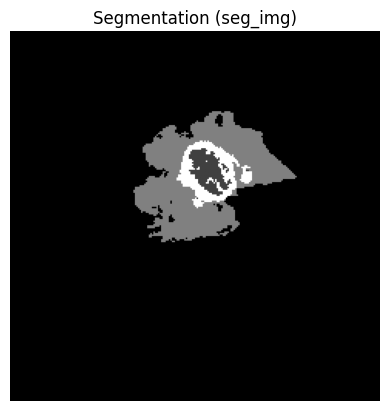

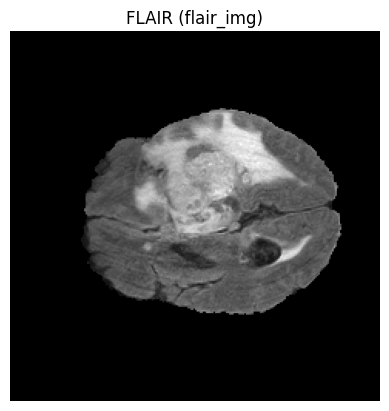

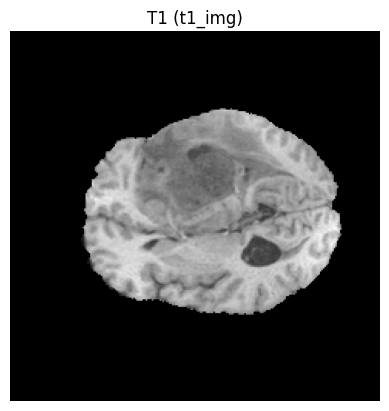

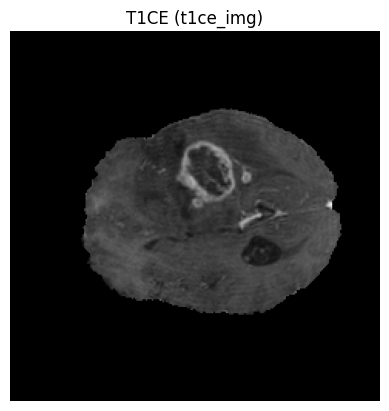

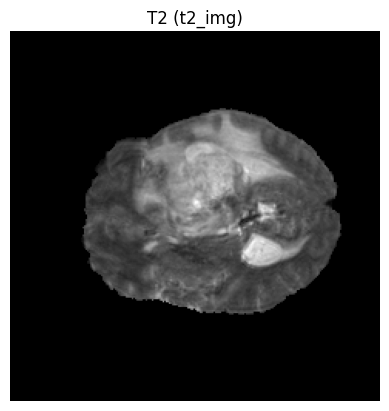

In [18]:
# Define a function to display a 2D slice from a 3D numpy array
z = np.random.randint(155) 
def display_slice(img, title):
 # Randomly choose a slice along the z-axis
    plt.imshow(img[:, :, z], cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display random 2D slices
display_slice(seg_img, 'Segmentation (seg_img)')
display_slice(flair_img, 'FLAIR (flair_img)')
display_slice(t1_img, 'T1 (t1_img)')
display_slice(t1ce_img, 'T1CE (t1ce_img)')
display_slice(t2_img, 'T2 (t2_img)')

In [27]:
## Inspecting the classes:

# Assuming you have a 3D numpy array named 'data'
print("Unique values seg:", np.unique(seg_img))
print("Unique values t1:", np.unique(t1_img))
print("Unique values t1ce:", np.unique(t1ce_img))
print("Unique values t2:", np.unique(t2_img))
print("Unique values flair:", np.unique(flair_img))


Unique values seg: [0. 1. 2. 4.]
Unique values t1: [  0.  25.  27.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194.
 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 207. 208.
 209. 210. 211. 212. 213. 

In [29]:
# put the data into the folders
import shutil
import random

final_project_path = '/home/jws2215/e6691-2024spring-project-jwss-jws2215' # vm
data_folder_path = os.path.join(final_project_path, 'BraTS2020')
old_data_folder = os.path.join(data_folder_path,'MICCAI_BraTS2020_TrainingData')
train_folder_path = os.path.join(data_folder_path, 'train')
valid_folder_path = os.path.join(data_folder_path, 'valid')
train_valid_split = 0.2


# Create directories if they don't exist
os.makedirs(train_folder_path, exist_ok=True)
os.makedirs(valid_folder_path, exist_ok=True)


# List all sample folders in the old data folder
sample_folders = [folder for folder in os.listdir(old_data_folder) 
                  if os.path.isdir(os.path.join(old_data_folder, folder)) 
                  and not folder.startswith('.')]
# Shuffle the sample folders
random.shuffle(sample_folders)

# Calculate split index
split_idx = int(len(sample_folders) * train_valid_split)

# Copy folders to train and valid directories
for folder in sample_folders[:split_idx]:
    src = os.path.join(old_data_folder, folder)
    dst = os.path.join(valid_folder_path, folder)
    shutil.copytree(src, dst)

for folder in sample_folders[split_idx:]:
    src = os.path.join(old_data_folder, folder)
    dst = os.path.join(train_folder_path, folder)
    shutil.copytree(src, dst)

In [31]:
# validation that it worked

# Count number of folders in valid and train folders
num_valid_folders = len([folder for folder in os.listdir(valid_folder_path) 
                         if os.path.isdir(os.path.join(valid_folder_path, folder))])
num_train_folders = len([folder for folder in os.listdir(train_folder_path) 
                         if os.path.isdir(os.path.join(train_folder_path, folder))])

print(f"Number of folders in 'valid': {num_valid_folders}")
print(f"Number of folders in 'train': {num_train_folders}")


Number of folders in 'valid': 20
Number of folders in 'train': 80
